<a href="https://colab.research.google.com/github/hisics/-datawhisperers_final-project_dsml2021/blob/main/datawhisperers_sentiment_analysis_amazon_apparel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - ML on Apparel Reviews at Amazon US
The Data Whisperers Team ✨  Amba | Bhavya | Sushma | Heba

#### Chosen project : Option 8 - Sentiment Analysis for Ecommerce

From Dany: Look at this document for reference,<br/>
https://colab.research.google.com/drive/1g6ZtYOOhGUj1WsiPpeaVPp5T7VFw234e?usp=sharing

DATA COLUMNS:
* marketplace       : 2 letter country code of the marketplace where the review was written.
*customer_id       : Random identifier that can be used to aggregate *reviews written by a single author.
*review_id         : The unique ID of the review.
*product_id        : The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
*product_parent    : Random identifier that can be used to aggregatereviews for the same product.
*product_title     : Title of the product.
*product_category  : Broad product category that can be used to group reviews  (also used to group the dataset into coherent parts).
*star_rating       : The 1-5 star rating of the review.
*helpful_votes     : Number of helpful votes.
*total_votes       : Number of total votes the review received.
*vine              : Review was written as part of the Vine program.
*verified_purchase : The review is on a verified purchase.
*review_headline   : The title of the review.
*review_body       : The review text.
*review_date       : The date the review was written.

#### Importing libaries and Apparel dataset

In [68]:
# (1) Import libraries
import pandas as pd
from distutils.util import strtobool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# plt.style.use('fivethirtyeight')

# # for advanced visualizations
# import plotly.offline as py
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# from plotly import tools
# init_notebook_mode(connected = True)
# import plotly.figure_factory as ff

In [69]:
# (2) Download product reviews from Amazon Datasets
# You can use reviews from Amazon Datasets for a particular product.
# Note that the data are quite large so do not run this cell unless you are willing to wait!
# For reference, visit:
# https://www.tensorflow.org/datasets/catalog/amazon_us_reviews
# https://s3.amazonaws.com/amazon-reviews-pds/readme.html
!curl -O https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  618M  100  618M    0     0  41.0M      0  0:00:15  0:00:15 --:--:-- 44.6M


In [70]:
!echo "y" | gzip -d amazon_reviews_us_Apparel_v1_00.tsv.gz

gzip: amazon_reviews_us_Apparel_v1_00.tsv already exists;	not overwritten


In [71]:
# (3.a) Read the contents of the folder 
!ls

amazon_reviews_us_Apparel_v1_00.tsv	sample_data
amazon_reviews_us_Apparel_v1_00.tsv.gz


In [72]:
# (3.b) Explore data (see what is categorial and numerical)

In [73]:
df = pd.read_table('amazon_reviews_us_Apparel_v1_00.tsv', delim_whitespace=False, error_bad_lines=False, nrows=100000)
df.info()

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\n'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        100000 non-null  object
 1   customer_id        100000 non-null  int64 
 2   review_id          100000 non-null  object
 3   product_id         100000 non-null  object
 4   product_parent     100000 non-null  int64 
 5   product_title      100000 non-null  object
 6   product_category   100000 non-null  object
 7   star_rating        100000 non-null  int64 
 8   helpful_votes      100000 non-null  int64 
 9   total_votes        100000 non-null  int64 
 10  vine               100000 non-null  object
 11  verified_purchase  100000 non-null  object
 12  review_headline    100000 non-null  object
 13  review_body        99947 non-null   object
 14  review_date        99997 non-null   object
dtypes: int64(5), object(10)
memory usage: 11.4+ MB


In [74]:
# To see how the data looks like and if any is boolean
df.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
99995,US,43330569,R209JPXL8VMOVJ,B00VW37AMU,354148485,"Cybertela Women's Nice Fish You Caught, Can.. ...",Apparel,5,0,0,N,Y,Five Stars,My girlfriend loved it.,2015-05-05
99996,US,25578439,R2ISQWVCXLRNXQ,B00VW367FG,90102146,Cybertela Women's If You Don’t Fish I See.. Fu...,Apparel,4,0,0,N,Y,Four Stars,Great shirt,2015-05-18
99997,US,4282714,RB6XI6R464ZQL,B00VW366V6,789256548,Asgard Blacksmith's Alliance Thor Men's T-Shirt,Apparel,5,0,0,N,Y,Five Stars,Sweet shirt,2015-06-29
99998,US,41294636,R2RW7ZCM8J5YGV,B00VW2UKTG,233863271,Naturana Women's Mastectomy Bra,Apparel,5,0,1,N,Y,Five Stars,very well made,2015-08-06
99999,US,10624669,RN6BUHLG6XC8U,B00VW2TT0W,255023016,Ah Pardon Me My Good Sir I Believe I May Have ...,Apparel,4,0,0,N,Y,So Great!,This was a hit at the baby shower!,2015-07-07


In [75]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,2.192162e+07,5.033726e+08,3.944590,1.599780,1.875920
std,1.658279e+07,2.886524e+08,1.399064,11.287327,11.788016
min,1.004700e+04,1.554700e+04,1.000000,0.000000,0.000000
25%,6.795861e+06,2.536043e+08,3.000000,0.000000,0.000000
50%,1.916066e+07,5.103228e+08,5.000000,0.000000,0.000000
75%,3.716944e+07,7.501726e+08,5.000000,1.000000,1.000000
max,5.309636e+07,9.999938e+08,5.000000,1655.000000,1679.000000


In [76]:
df.groupby('star_rating').describe()

customer_id                              ... total_votes             
                  count          mean           std  ...         50%  75%     max
star_rating                                          ...                         
1               11720.0  2.110066e+07  1.646005e+07  ...         0.0  2.0   685.0
2                6690.0  2.273772e+07  1.637359e+07  ...         0.0  1.0    85.0
3               10402.0  2.235946e+07  1.633604e+07  ...         0.0  1.0   634.0
4               17787.0  2.241069e+07  1.655498e+07  ...         0.0  1.0   563.0
5               53401.0  2.175137e+07  1.668157e+07  ...         0.0  1.0  1679.0

[5 rows x 32 columns]

###Cleaning data and converting data types


#### Pre-processing the columns without review text

In [77]:
# Checking if marketplace is only in the US
df.marketplace.unique()

array(['US'], dtype=object)

In [78]:
# Checking unique values of each row in all columns
n = df.nunique(axis=0)
print(
    "Total number of rows in this data set is:{}\nNumber of unique values in each column for in this dataset is:\n"
    .format(len(df)), n)
# outcome --> drop marketplace-category-reviewID
# outcome --> bool vine verified purchase

Total number of rows in this data set is:100000
Number of unique values in each column for in this dataset is:
 marketplace               1
customer_id           85149
review_id            100000
product_id            66229
product_parent        41084
product_title         39656
product_category          1
star_rating               5
helpful_votes           206
total_votes             215
vine                      2
verified_purchase         2
review_headline       53335
review_body           92599
review_date             173
dtype: int64


In [79]:
# Cleaning
# (1) Drop: marketplace + product_category + review_id
df.drop(['marketplace','product_category','review_id'], axis=1, inplace=True)

# (2) Map: vine + verified_purchase (y:1, n:0)
YN_to_bool = {'Y': 1,'N': 0}
df['vine'] = df['vine'].map( YN_to_bool )
df['verified_purchase'] = df['verified_purchase'].map( YN_to_bool)

# (3) Datetime: review_date
df['review_date'] = pd.to_datetime(df['review_date'])

# (4) Create a year column for EDA
df['Year'] = df.review_date.dt.year

# (5) Drop the rows where there are no reviews
df.dropna(subset = ['review_body'], inplace = True)

 
# (6) Combine the review headline and review date columns
df['review_body'] = df['review_headline'] + ' ' + df['review_body']
del df['review_headline']

# (7) Adding a length column for analyzing the length of the reviews

df['length'] = df['review_body'].apply(len)

# (8) Creating numerical df -> df_num for EDA
cat_list = ['product_parent','product_id','customer_id','product_title','review_body','length']

# (9) Creating categorical df -> df_cat
df_num = df.drop(cat_list, inplace = False , axis = 1) 
df_cat = df[cat_list]

# (10) Print to see the null rows if any
null_columns=df.columns[df.isnull().any()]
df[df["review_date"].isnull()] #[null_columns] add to tail end to show null columns when that particular colum is null

df.head(1)

# # creating numerical df -> df_num
# # creating categorical df -> df_cat
# cat_list = ['marketplace','review_id','product_id','product_title','product_category','vine','verified_purchase','review_headline','review_body','review_date']
# df_num = df.drop(cat_list, inplace = False , axis = 1) 

# df_cat = df[cat_list]



,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date,Year,length
0,32158956,B01KL6O72Y,24485154,Easy Tool Stainless Steel Fruit Pineapple Core...,4,0,0,0,1,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKIN...,2013-01-14,2013.0,2961


In [80]:
df.info()
df_cat.info() 
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99947 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        99947 non-null  int64         
 1   product_id         99947 non-null  object        
 2   product_parent     99947 non-null  int64         
 3   product_title      99947 non-null  object        
 4   star_rating        99947 non-null  int64         
 5   helpful_votes      99947 non-null  int64         
 6   total_votes        99947 non-null  int64         
 7   vine               99947 non-null  int64         
 8   verified_purchase  99947 non-null  int64         
 9   review_body        99947 non-null  object        
 10  review_date        99944 non-null  datetime64[ns]
 11  Year               99944 non-null  float64       
 12  length             99947 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(3)
memory 

#### Pre-processing the text fields
##### Useful resource for cleaning text
https://medium.com/mlearning-ai/10-python-functions-you-need-to-apply-before-you-build-your-nlp-sentiment-analysis-model-874a37e0217e

In [81]:
# Removing the hashtags
import re      # Import REGEX
def remove_mentions(text):
  text = re.sub("@[A-Za-z0-9_]+","", text)
  text = re.sub("#[A-Za-z0-9_]+","", text)
  return text

df['review_body'] = df.apply(lambda row: remove_mentions(row['review_body']), axis=1)

In [82]:
# Removing the emojis |

# # Reference code: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# def remove_emoji(review_body):
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                u"\U00002500-\U00002BEF"  # chinese char
#                                u"\U00002702-\U000027B0"
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                u"\U0001f926-\U0001f937"
#                                u"\U00010000-\U0010ffff"
#                                u"\u2640-\u2642"
#                                u"\u2600-\u2B55"
#                                u"\u200d"
#                                u"\u23cf"
#                                u"\u23e9"
#                                u"\u231a"
#                                u"\ufe0f"  # dingbats
#                                u"\u3030"
#                                "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

In [83]:
# Importing text cleaning libraries 
# Tokenizer: Tokenization of data. At one stage we will need to deal with our text as a words list to iterate between the words and apply certain functions on it

import nltk         #Natural language processing tool-kit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [84]:
# lower all upper case and enumerate words into a list
df['review_body'] = df['review_body'].str.lower()
# df['review_body'] = df['review_body'].values.tolist()
df['review_body']

0        ★ these really do work great with some tweakin...
1        favorite for winter. very warm! i love this dr...
2        great socks for the money. nice socks, great c...
3        slick hat! i bought this for my husband and wo...
4        i would do it again! perfect dress and the cus...
                               ...                        
99995                   five stars my girlfriend loved it.
99996                               four stars great shirt
99997                               five stars sweet shirt
99998                            five stars very well made
99999         so great! this was a hit at the baby shower!
Name: review_body, Length: 99947, dtype: object

In [85]:
# Removal of numbers and digits
import re      # Import REGEX
def remove_numbers(text):
  text = re.sub(r'\d+', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_numbers(row['review_body']), axis=1)


In [86]:
# Removal of special characters
import re, string, unicodedata # Import Regex, string and unicodedata.
def remove_non_ascii(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words

df['review_body'] = df.apply(lambda row: remove_non_ascii(row['review_body']), axis=1)

In [87]:
# Removal of punctuation
import re      # Import REGEX
def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_punctuation(row['review_body']), axis=1)


In [88]:
# Import nltk stop words
# # Removal of stop words
import nltk
from nltk.corpus import stopwords            #Stopwords corpus
stopwords = stopwords.words('english')

In [89]:
# Customising the stop words - we need to review this
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# # Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))

In [90]:
# after cleaning text, bring the words into a list
df['review_body'] = df.apply(lambda row: nltk.word_tokenize(row['review_body']), axis=1)
df['review_body']

0        [these, really, do, work, great, with, some, t...
1        [favorite, for, winter, very, warm, i, love, t...
2        [great, socks, for, the, money, nice, socks, g...
3        [slick, hat, i, bought, this, for, my, husband...
4        [i, would, do, it, again, perfect, dress, and,...
                               ...                        
99995             [five, stars, my, girlfriend, loved, it]
99996                          [four, stars, great, shirt]
99997                          [five, stars, sweet, shirt]
99998                      [five, stars, very, well, made]
99999    [so, great, this, was, a, hit, at, the, baby, ...
Name: review_body, Length: 99947, dtype: object

### EDA and Feature Engineering

In [91]:
# Quick check: Using discriptive statistics + measures of dispersion
# Note: customer_id and product_parent are random numbers not for descriptive analysis
df_discriptive = df.drop(['customer_id', 'product_parent'],axis = 1,inplace = False)
df_discriptive.describe()

,star_rating,helpful_votes,total_votes,vine,verified_purchase,Year,length
count,99947.000000,99947.000000,99947.000000,99947.000000,99947.000000,99944.000000,99947.000000
mean,3.944611,1.592004,1.867490,0.003672,0.872833,2014.999530,197.666183
std,1.399111,11.264699,11.762749,0.060486,0.333162,0.039632,270.747406
min,1.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,5.000000
25%,3.000000,0.000000,0.000000,0.000000,1.000000,2015.000000,51.000000
50%,5.000000,0.000000,0.000000,0.000000,1.000000,2015.000000,115.000000
75%,5.000000,1.000000,1.000000,0.000000,1.000000,2015.000000,243.000000
max,5.000000,1655.000000,1679.000000,1.000000,1.000000,2015.000000,17165.000000


In [92]:
df.groupby('length').describe().sample(10)

customer_id                              ...    Year                
             count          mean           std  ...     50%     75%     max
length                                          ...                        
491           25.0  2.482063e+07  1.673764e+07  ...  2015.0  2015.0  2015.0
1002           6.0  2.560221e+07  1.043954e+07  ...  2015.0  2015.0  2015.0
1188           1.0  2.155477e+07           NaN  ...  2015.0  2015.0  2015.0
438           37.0  2.161005e+07  1.525751e+07  ...  2015.0  2015.0  2015.0
212          155.0  2.270899e+07  1.722362e+07  ...  2015.0  2015.0  2015.0
909            6.0  2.596179e+07  1.347251e+07  ...  2015.0  2015.0  2015.0
1591           3.0  4.122668e+07  1.260687e+07  ...  2015.0  2015.0  2015.0
2393           1.0  2.655003e+07           NaN  ...  2015.0  2015.0  2015.0
27           633.0  1.949857e+07  1.585386e+07  ...  2015.0  2015.0  2015.0
182          191.0  2.313233e+07  1.676656e+07  ...  2015.0  2015.0  2015.0

[10 rows x 64 columns]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


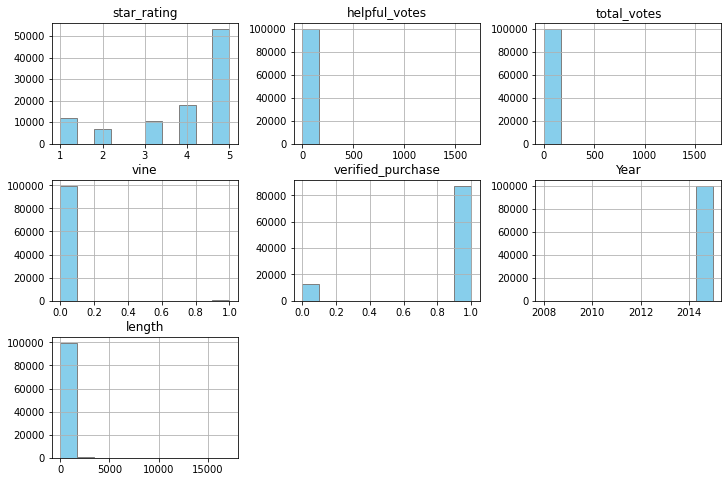

In [93]:
# Check the distribution of the star rating with the DataFrame | reference chart: https://www.datacamp.com/community/tutorials/histograms-matplotlib
# plt.hist(df.star_rating, bins='auto', color = "skyblue", ec='grey')
# plt.gca().set(title='Frequency Histogram | Review Stars |', ylabel='Frequency',xlabel = 'stars',alpha=0.7, rwidth=0.85);
# plt.show()

fig = plt.figure(figsize = (12,8))
ax = fig.gca()
df_discriptive.hist(ax=ax, color = "skyblue", ec='grey')
plt.show()

# Clustering per groups of product parent | votes per product parent
# Sentiment (from -ve) most common words for improvement | from (+ve) most common words for gap analysis
# we will need to scale our stars to min max
# then our scaled stars are our sentiment label, and text is the features? 

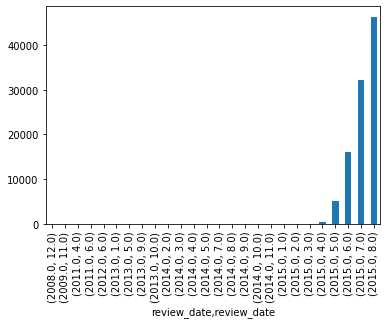

In [94]:
# Looking at year and month for review | seems we can extra clean outliers outside 2015 #todo
df.star_rating.groupby([df["review_date"].dt.year, df["review_date"].dt.month]).count().plot(kind="bar")

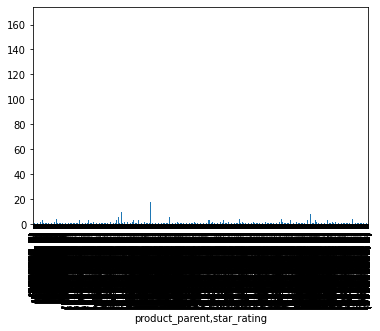

In [95]:
# Looking at product parent | 
df.product_id.groupby([df["product_parent"],df['star_rating']]).count().plot(kind="bar")

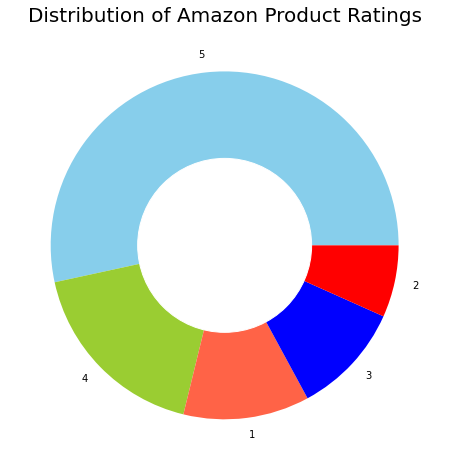

In [96]:
# Distribution of Amazon Product Ratings
ratings = df["star_rating"].value_counts()
numbers = ratings.index
quantity = ratings.values

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Distribution of Amazon Product Ratings", fontsize=20)
plt.show()

In [98]:
def sentiment(row):
    
    '''This function returns sentiment value based on the star_rating from the user'''
    
    if row['star_rating'] == 3.0:
        val = 'Neutral'
    elif row['star_rating'] == 1.0 or row['star_rating'] == 2.0:
        val = 'Negative'
    elif row['star_rating'] == 4.0 or row['star_rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [99]:
#Applying the function in our new column
df['sentiment'] = df.apply(sentiment, axis=1)
df.head()

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date,Year,length,sentiment
0,32158956,B01KL6O72Y,24485154,Easy Tool Stainless Steel Fruit Pineapple Core...,4,0,0,0,1,"[these, really, do, work, great, with, some, t...",2013-01-14,2013.0,2961,Positive
1,2714559,B01ID3ZS5W,363128556,V28 Women Cowl Neck Knit Stretchable Elasticit...,5,1,2,0,1,"[favorite, for, winter, very, warm, i, love, t...",2014-03-04,2014.0,403,Positive
2,12608825,B01I497BGY,811958549,James Fiallo Men's 12-Pairs Low Cut Athletic S...,5,0,0,0,1,"[great, socks, for, the, money, nice, socks, g...",2015-07-12,2015.0,114,Positive
3,25482800,B01HDXFZK6,692205728,Belfry Gangster 100% Wool Stain-Resistant Crus...,5,0,0,0,1,"[slick, hat, i, bought, this, for, my, husband...",2015-06-03,2015.0,194,Positive
4,9310286,B01G6MBEBY,431150422,JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...,5,0,0,0,1,"[i, would, do, it, again, perfect, dress, and,...",2015-06-12,2015.0,72,Positive


### Choose the label and features

In [100]:
# (4) Choose the label and features
selectedFeatures = ['product_id','star_rating', 'total_votes', 'helpful_votes','vine','verified_purchase']
features = df.loc[:, selectedFeatures]

features[0:10]


,product_id,star_rating,total_votes,helpful_votes,vine,verified_purchase
0,B01KL6O72Y,4,0,0,0,1
1,B01ID3ZS5W,5,2,1,0,1
2,B01I497BGY,5,0,0,0,1
3,B01HDXFZK6,5,0,0,0,1
4,B01G6MBEBY,5,0,0,0,1
5,B01FWRXN0Y,5,0,0,0,1
6,B01EXNH1HE,5,0,0,0,1
7,B01E7OL09O,4,0,0,0,1
8,B01DXHX81O,5,0,0,0,1
9,B01DDULIJK,3,0,0,0,1


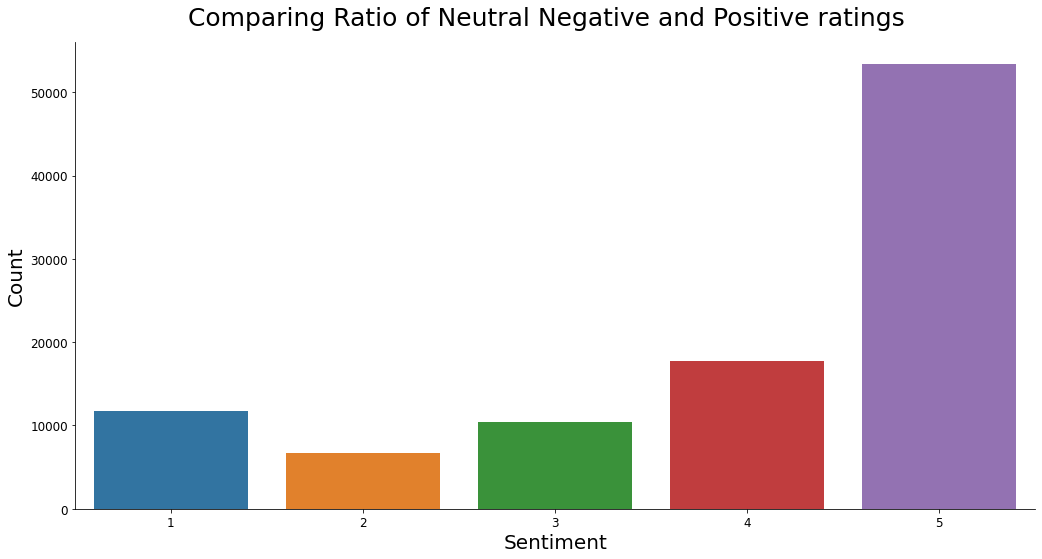

In [101]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "star_rating", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

In [103]:
# # Group by product and Rating class
# df.groupby("product_title")["review_body"].unique()

SyntaxError: ignored

In [104]:
# Group by product and Rating class
df.groupby("product_title")["product_id"].count()

product_title
#03 Mystiqueshapes Multi-way Convertible Infinity Transformer Pencil Dress                            1
#04 Mystiqueshapes Multi-way Convertible Infinity Transformer Midi Dress                              1
#1 BEST Waist Trainer on Amazon - Hourglass Fashion Corset Weight Loss Cincher                       16
#1 Men’s Handkerchief Hankie 6 pc Set White Soft, Durable, Absorbent Organic Bamboo                   1
#906 - Hashtag Adult Men's T-Shirt, Black, X-Large                                                    1
                                                                                                     ..
zeroUV - Emerald Light Effects Geometric Prism Kaleidescope Glasses                                   7
zhao-king Sexy Nursing Maternity Camisole Tank Bra                                                    1
zhao-king® Seamless Push up Nursing and Maternity Bra Wireless Underwear                              1
“I Do What I Want” Purple Girls Toddler T-shirt wi

In [106]:
# Group by product and Rating class
df.groupby("product_title")["sentiment"].unique()

product_title
#03 Mystiqueshapes Multi-way Convertible Infinity Transformer Pencil Dress                                              [Positive]
#04 Mystiqueshapes Multi-way Convertible Infinity Transformer Midi Dress                                                [Negative]
#1 BEST Waist Trainer on Amazon - Hourglass Fashion Corset Weight Loss Cincher                       [Positive, Negative, Neutral]
#1 Men’s Handkerchief Hankie 6 pc Set White Soft, Durable, Absorbent Organic Bamboo                                     [Positive]
#906 - Hashtag Adult Men's T-Shirt, Black, X-Large                                                                      [Positive]
                                                                                                                 ...              
zeroUV - Emerald Light Effects Geometric Prism Kaleidescope Glasses                                            [Positive, Neutral]
zhao-king Sexy Nursing Maternity Camisole Tank Bra                   

In [107]:
# (4) Choose the label and features

In [108]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

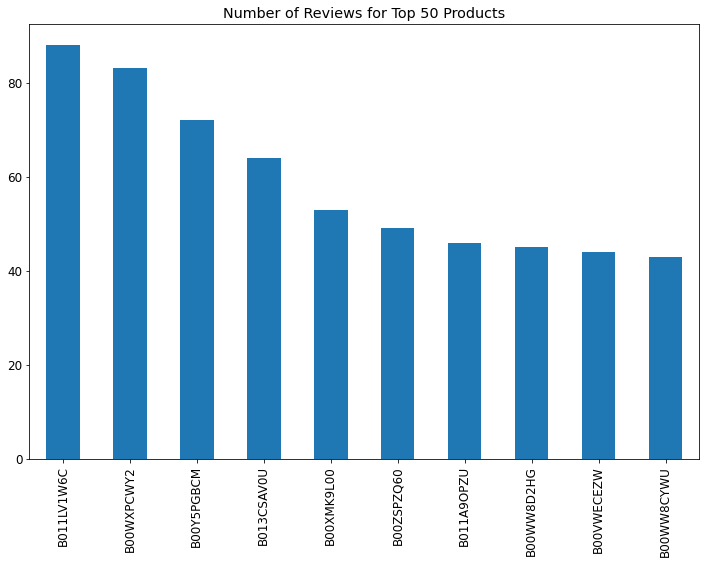

In [109]:
# Plot number of reviews for top 50 products
products = df["product_id"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

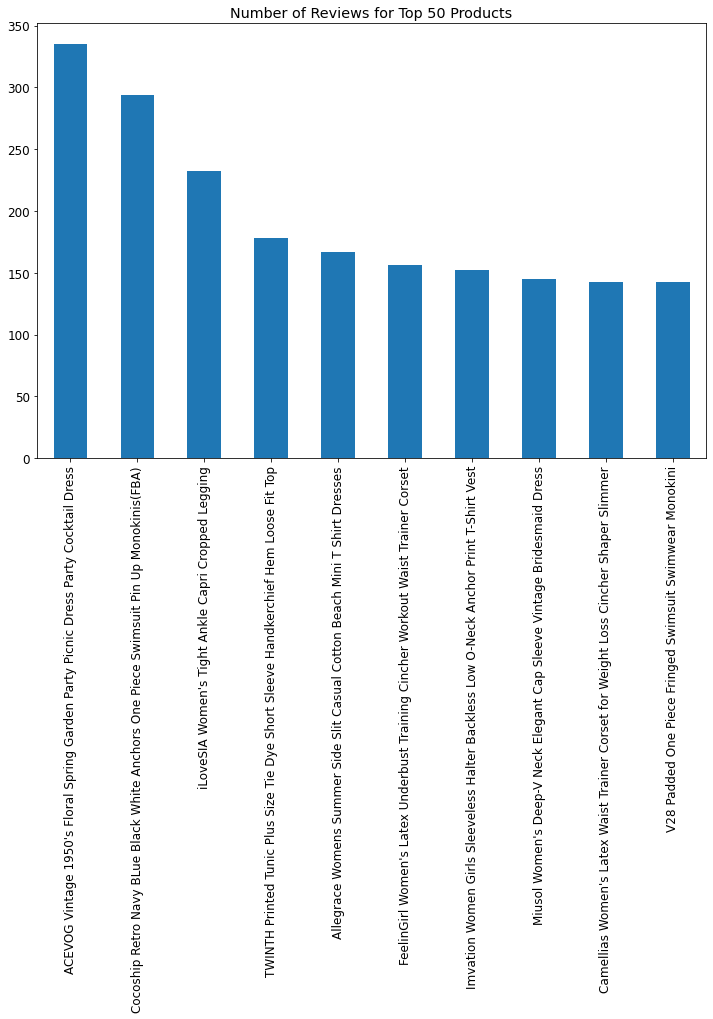

In [110]:
# Plot number of reviews for top 50 products
products = df["product_title"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

In [111]:
# Word Count per Review type
from textblob import TextBlob
df['text_word_count']= df.apply(lambda row: len(row['review_body']), axis=1)
# df["text_word_count"] = temp_df["Text"].apply(lambda text: len(text.split()))

In [112]:
df[df.star_rating==5].text_word_count.median()

18.0

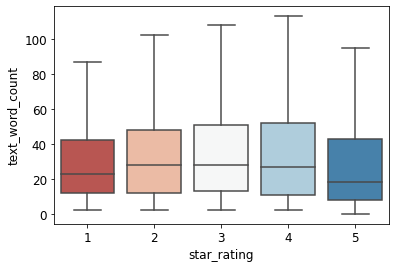

In [113]:
sns.boxplot(x='star_rating',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

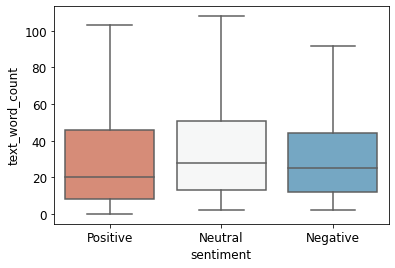

In [114]:
sns.boxplot(x='sentiment',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

In [115]:
# (6) Confirm data is ready with further exploratory analysis

*   Maximum reviews are positive
*   Product with Max reviews is Tummy slimming belt
*   This shows people mainly target losing weight :)
*   Postive reviews has lesser words compared to Neutral and negative. Neutral commets are ones with most words. Which can be critic comment or unsatisfied customers.

### Popular words in Review

In [116]:
pos = df_discriptive.loc[df['classes'] == 'positive']
pos = pos[0:25000]

neg = df.loc[df['classes'] == 'negative']
neg = neg[0:25000]

KeyError: ignored

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

def create_Word_Corpus(temp):
    words_corpus = ''
    for val in temp["review_body"]:
        text = str(val).lower()
        #text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus
        

In [ ]:
# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))

In [ ]:
# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
#Visuallizing popular positive words
plot_Cloud(pos_wordcloud)

In [ ]:
#Visuallizing popular negative words
plot_Cloud(neg_wordcloud)

### Data Split, Machine Learning

In [ ]:
# (7) Training, Testing (and/or Validation) data split 

# for example, 60/20/20

In [ ]:
# (7.b) If using Deep Learning, building the model

# Add Input Layer
# Add Hidden Layers
# Add Output

In [ ]:
# (8) Training the Machine Learning Model (i.e, Fitting the Model)

In [ ]:
# (9) Evaluate the model metrics for Training (and/or Validation) data

In [ ]:
# (10) Evaluate the model metris for Testing data


# If metrics are poor, optimize either (a) the data, (b) the hyperpamaters

In [ ]:
# (11) Use the model for prediction

In [ ]:
# (12) Write final predicted data  (e.g, to CSV or JSON, etc.)

In [ ]:
df_cleaned = df.head(100000)
df_cleaned['star_rating'].count()
df_cleaned['star_rating'].unique()
df_cleaned['star_rating'].value_counts()
# indexNames = df_cleaned[ df_cleaned['star_rating'] == 'star_rating' ].index
# df_cleaned.drop(indexNames,inplace=True)
# df_cleaned.dropna(inplace=True)

In [ ]:
from nltk.corpus import stopwords
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
df_cleaned.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( df_cleaned['review_body'], df_cleaned['star_rating'], test_size=0.33, random_state=42)

In [ ]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=500,C=0.1,random_state=40,solver='newton-cg')),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=500,C=0.1,random_state=40,solver='newton-cg')),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('clf', DecisionTreeClassifier()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf', DecisionTreeClassifier()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
from sklearn.svm import LinearSVC
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf',LinearSVC()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

#### Using KNN

In [ ]:
def partition(x):
    if x<3:
        return 'Negative'
    elif x>3:
        return 'Positive'
    return 'Neutral'

actualScore = df['star_rating']
positiveNegative = actualScore.map(partition)
df['Score'] = positiveNegative

In [ ]:
df['Time'] = df['review_date']
sortedData = df.sort_values('product_id',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"customer_id","Time","review_body"},keep="first",inplace=False)

final = final[final.helpful_votes >= final.total_votes-final.helpful_votes]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'Positive']
finalp = finalp.sample(frac=0.008,random_state=2) #0.055

finaln = final[final.Score == 'Negative']
finaln = finaln.sample(frac=0.1,random_state=1) #0.25

finalne = final[final.Score == 'Neutral']
finalne = finalne.sample(frac=0.02,random_state=4) #0.25

final = pd.concat([finalp,finaln, finalne],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [ ]:
import re
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
all_neutral_words=[]
s=''

for sent in final['review_body'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    if(final['Score'].values)[i] == 'Neutral':
                        all_neutral_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [ ]:
from sklearn.model_selection import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=8)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

In [ ]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )

In [ ]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

"""
df_test = pd.read_csv('test.csv')

df_test = df_test.dropna()

X_test = df_test['review_body']
y_test = df_test['ratings']

count_vect_test = CountVectorizer() 
final_bow_count_test = count_vect.fit_transform(X_test)
final_bow_np_test = StandardScaler(with_mean=False).fit_transform(final_bow_count_test)

X_test = final_bow_np_test
"""

In [ ]:
import numpy as np

In [ ]:
myList = list(range(0,15))

optimal_k = find_optimal_k(X_train ,y_train,myList)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=8)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [ ]:
print("Accuracy for KNN model with Bag of words is ",round(accuracy_score(y_test ,pred),3))

#### EDA by Spacy

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
stopwords = list(STOP_WORDS)

In [ ]:
import string
punctuations = string.punctuation
from spacy.lang.en import English
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    return mytokens
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
#Custom Transformer using spaCy
class predictors(TransformerMixin):
    
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self,deep=True):
        return{}
    
# Basic function to clean the text
def clean_text(text):
    return text.strip().lower()
tfdifVect = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
from spacy import displacy

In [ ]:
# Breaking down a review into dependencies
doc = nlp(df['review_body'][8]) 
displacy.render(doc,style='dep',jupyter=True)

In [ ]:
#X = data.drop('star_rating',axis=1)
X = df['review_body']
y = df['sentiment']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

#### Support Vector Machines

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                 ('tfidfVect', tfdifVect),
                ('classifier',classifier),])

In [ ]:
y_train

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                 ('tfidfVect', tfdifVect),
                ('classifier',classifier),])

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
count = 1
for (sample,pred) in zip(X_test[0:10],sample_prediction[0:10]):
    print('\n',count,')')
    print(sample,"'PREDICTION':", pred)
    count += 1

In [ ]:
#Test Accuracy
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier =  LogisticRegression()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
#Test Accuracy
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not good"])

In [ ]:
pipe.predict(["Nice dress, good fitting"])

In [ ]:
pipe.predict(["perfect size, good material"])